In [46]:
import numpy as np
import pandas as pd
import torch
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
from wordfreq import zipf_frequency
from wordfreq import word_frequency

import matplotlib.pyplot as plt
from collections import Counter

In [47]:
file = open("valid-wordle-words.txt")
words = file.read().split()
df = pd.read_excel("Problem_C_Data_Wordle.xlsx")
subwords = df["Word"]
avgscores = df["avg_score"]
fullscores = df[
    [
        "1 try",
        "2 tries",
        "3 tries",
        "4 tries",
        "5 tries",
        "6 tries",
        "7 or more tries (X)",
    ]
]

CZERO = ord("a")

In [48]:
wordfreq = np.asarray(
    [word_frequency(words[i], "en") for i in range(len(words))], dtype=np.float64
)
maxfreq = max(wordfreq)
wordfreq = wordfreq / maxfreq
wordfreq = 1 / (1 + np.exp(-(wordfreq - 0.5) * 3))

avgscores = np.asarray(avgscores) - min(avgscores)
avgscores = avgscores / max(avgscores)

fullscores = np.asarray(fullscores)
fullscores = fullscores.T / (np.sum(fullscores, axis=1))
fullscores = fullscores.T
fullscores=fullscores*100

partscores=np.concatenate([fullscores[:,1:3],fullscores[:,4:6]],axis=1)

In [49]:
charpos = np.zeros((26, 6))
for i in range(len(words)):
    for j in range(5):
        charpos[ord(words[i][j]) - CZERO][j] += wordfreq[i]
        charpos[ord(words[i][j]) - CZERO][5] += wordfreq[i]

In [50]:
charcombo = np.zeros((26, 26))
for i in range(len(words)):
    for j in range(4):
        a = ord(words[i][j]) - ord("a")
        b = ord(words[i][j + 1]) - ord("a")
        charcombo[a][b] += wordfreq[i]

In [51]:
count = 0
charcomboele = [(i, j, charcombo[i][j]) for i in range(26) for j in range(26)]
charcomboord = np.zeros((26, 26))
charcomboele = sorted(charcomboele, key=lambda e: e[2])
for i in range(26 * 26):
    a = charcomboele[i][0]
    b = charcomboele[i][1]
    c = charcomboele[i][2]
    charcomboord[a][b] = count
    if i < 26 * 26 - 1:
        if c != charcomboele[i + 1][2]:
            count += 1

In [52]:
charnumber = np.zeros(len(words))
count = 0
for i in range(len(words)):
    count = 0
    word = words[i]
    for j in range(5):
        same = False
        for k in range(j):
            if word[k] == word[j]:
                same = True
                break
        if not same:
            count += 1
    charnumber[i] = count

In [53]:
def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

In [54]:
def getfeaturefq(word):
    # charnumber
    f0 = 0
    for j in range(5):
        same = False
        for k in range(j):
            if word[k] == word[j]:
                same = True
                break
        if not same:
            f0 += 1
    dummy = np.zeros((5))
    dummy[f0 - 1] = 1

    # charfeq
    f1 = 0
    for i in range(5):
        f1 += charpos[ord(word[i]) - ord("a")][5]
    f1 /= np.sum(charpos[:, -1])

    # charpos
    f2 = 0
    for i in range(5):
        f2 += charpos[ord(word[i]) - ord("a")][i]
    f2 /= np.sum(charpos[:, 0]) * 5

    # charcombo
    f3 = 0
    for i in range(4):
        a = ord(word[i]) - ord("a")
        b = ord(word[i + 1]) - ord("a")
        f3 += charcombo[a][b]
    f3 /= np.sum(charcombo)

    f4 = syllable_count(word)

    f5 = zipf_frequency(word, "en")
    f6 = word_frequency(word, "en")

    lo = 0
    hi = len(words) - 1
    while hi > lo:
        mid = (lo + hi) // 2
        if words[mid] < word:
            lo = mid + 1
        else:
            hi = mid
    f7 = wordfreq[lo]

    return np.concatenate((dummy, np.asarray([f1, f2, f3, f4, f5, f6, f7])), axis=0)
    # return np.asarray([f1])

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [56]:
class MyDataset(Dataset):

    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        # self.y = torch.unsqueeze(torch.FloatTensor(y),1)
        self.y = torch.FloatTensor(y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [57]:
features = np.asarray([getfeaturefq(word) for word in subwords])
target =np.asarray( partscores)

In [58]:
train_data = MyDataset(features[0:300], target[0:300])
test_data = MyDataset(features[300:358], target[300:358])
train_dataloader = DataLoader(dataset=train_data, batch_size=10,shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=10,shuffle=True)


class NeuralNetwork(nn.Module):
    def __init__(self, xsize, ysize):
        super(NeuralNetwork, self).__init__()
        const=64
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(xsize, const),
            nn.ReLU(),
            nn.Linear(const,const),
            nn.ReLU(),
            nn.Linear(const, ysize),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(len(features[0]), len(target[0])).to(device)

In [59]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    totalloss = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalloss += loss.item()

        # if batch % 100 == 0:
        # loss, current = loss.item(), (batch + 1) * len(X)
        # print(batch,f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return totalloss / num_batches


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss
    # print(f" Avg loss: {test_loss:>8f} \n")

In [60]:
learning_rate = 1e-3
batch_size = 150
epochs = 1000

In [61]:
# loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# for t in range(epochs):
#     # print(f"Epoch {t+1}\n-------------------------------")
#     losstr = train_loop(train_dataloader, model, loss_fn, optimizer)
#     losste= test_loop(test_dataloader, model, loss_fn)
#     print(f"Epoch {t+1:>3} train loss {losstr:>7f} test loss {losste:>7f}")
# print("Done!")
model=torch.load('nnmodel.pt')

In [62]:
def trans(fullsc):
    # total = 0
    # for i in range(len(fullsc)):
    #     total += fullsc[i] * (i + 1)
    # return total
    return fullsc[0]+fullsc[1]

def avgtry(dist):
    total = 0
    for i in range(len(dist)):
        total += (i + 1) * dist[i] / 100
    return total

In [63]:
def func3(try23):
    if try23 >= 30:
        return -0.2739195*try23+44.30284419
        # return (-1.01707625 * try23) + (-1.55883301 * try56) + 116.31233276
        # return np.sum(reg2.coef_[0]*np.asarray([try23,try56]))+reg2.intercept_
    elif try23 <=20:
        return 0.97942356 * try23 + 15.44568885
        # return reg.coef_[0][0]*try23+reg.intercept_
    else:
        return 34.21147628611258
        # return middlemean

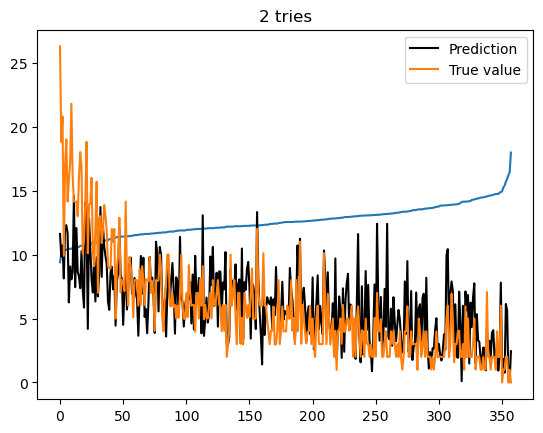

In [64]:
# 2
prescore = model(torch.FloatTensor(features))
prescore = np.asarray(torch.detach(prescore))


pairs = [
    (
        avgtry(fullscores[i]),
        prescore[i][0],
        fullscores[i][1],
    )
    for i in range(len(subwords))
]

pairs = np.asarray(sorted(pairs, key=lambda e: e[0])).T
plt.plot(np.arange(len(subwords)), pairs[0] * 3)
plt.plot(np.arange(len(subwords)), pairs[1], c="black", label="Prediction")
plt.plot(np.arange(len(subwords)), pairs[2], label="True value")
# plt.plot(np.arange(len(subwords)), pairs[3], c="black")
# plt.plot(np.arange(len(subwords)), pairs[4])
plt.title("2 tries")
plt.legend()

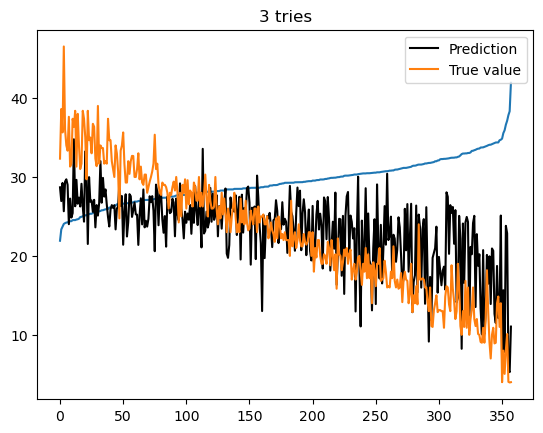

In [65]:
pairs = [
    (
        avgtry(fullscores[i]),
        prescore[i][1],
        fullscores[i][2],
    )
    for i in range(len(subwords))
]

pairs = np.asarray(sorted(pairs, key=lambda e: e[0])).T
plt.plot(np.arange(len(subwords)), pairs[0] * 7)
plt.plot(np.arange(len(subwords)), pairs[1], c="black", label="Prediction")
plt.plot(np.arange(len(subwords)), pairs[2], label="True value")
# plt.plot(np.arange(len(subwords)), pairs[3], c="black")
# plt.plot(np.arange(len(subwords)), pairs[4])
plt.title("3 tries")
plt.legend()

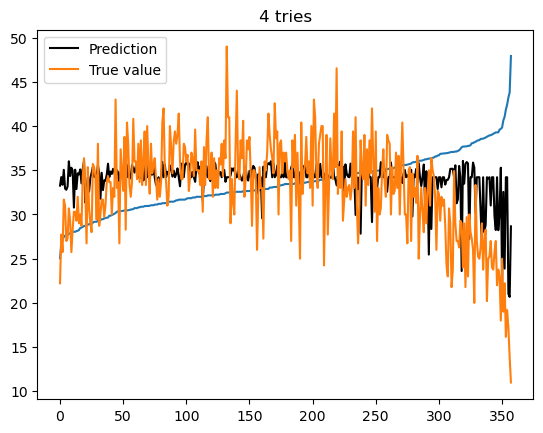

In [66]:
pairs = [
    (
        avgtry(fullscores[i]),
        prescore[i][0] + prescore[i][1],
        prescore[i][2] + prescore[i][3],
        func3(prescore[i][0] + prescore[i][1]),
        fullscores[i][3],
    )
    for i in range(len(subwords))
]

pairs = np.asarray(sorted(pairs, key=lambda e: e[0])).T
plt.plot(np.arange(len(subwords)), pairs[0] * 8)
# plt.plot(np.arange(len(subwords)), pairs[1])
# plt.plot(np.arange(len(subwords)), pairs[2])
plt.plot(np.arange(len(subwords)), pairs[3], c="black", label="Prediction")
plt.plot(np.arange(len(subwords)), pairs[4], label="True value")
plt.title("4 tries")
plt.legend()

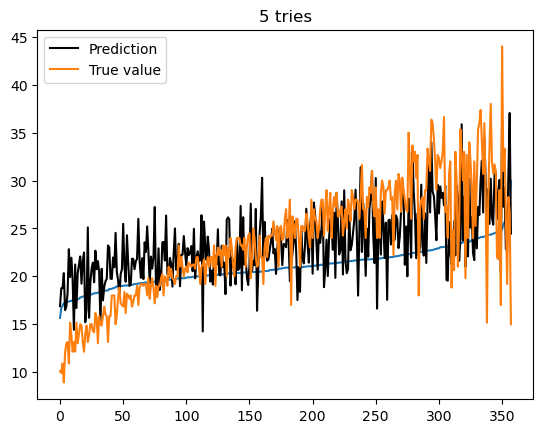

In [67]:
pairs = [
    (
        avgtry(fullscores[i]),
        prescore[i][2],
        fullscores[i][4],
    )
    for i in range(len(subwords))
]

pairs = np.asarray(sorted(pairs, key=lambda e: e[0])).T
plt.plot(np.arange(len(subwords)), pairs[0] * 5)
plt.plot(np.arange(len(subwords)), pairs[1], c="black", label="Prediction")
plt.plot(np.arange(len(subwords)), pairs[2], label="True value")
plt.title("5 tries")
plt.legend()

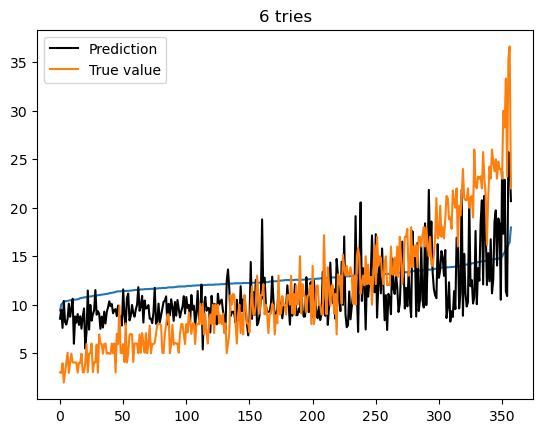

In [68]:
pairs = [
    (
        avgtry(fullscores[i]),
        prescore[i][3],
        fullscores[i][5],
    )
    for i in range(len(subwords))
]

pairs = np.asarray(sorted(pairs, key=lambda e: e[0])).T
plt.plot(np.arange(len(subwords)), pairs[0] * 3)
plt.plot(np.arange(len(subwords)), pairs[1], c="black", label="Prediction")
plt.plot(np.arange(len(subwords)), pairs[2], label="True value")
plt.title("6 tries")
plt.legend()

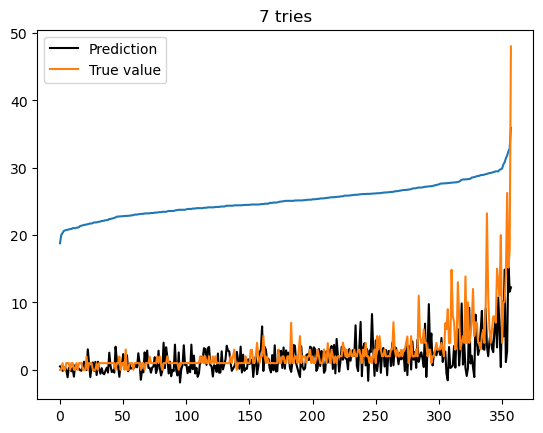

In [69]:
pairs = [
    (
        avgtry(fullscores[i]),
        100 - func3(prescore[i][0] + prescore[i][1]) - np.sum(prescore[i]) - 0.472067,
        fullscores[i][6],
    )
    for i in range(len(subwords))
]

pairs = np.asarray(sorted(pairs, key=lambda e: e[0])).T
plt.plot(np.arange(len(subwords)), pairs[0] * 6)
plt.plot(np.arange(len(subwords)), pairs[1], c="black", label="Prediction")
plt.plot(np.arange(len(subwords)), pairs[2], label="True value")
# plt.plot(np.arange(len(subwords)), pairs[3])
# plt.scatter(pairs[2],pairs[1])
plt.title("7 tries")
plt.legend()

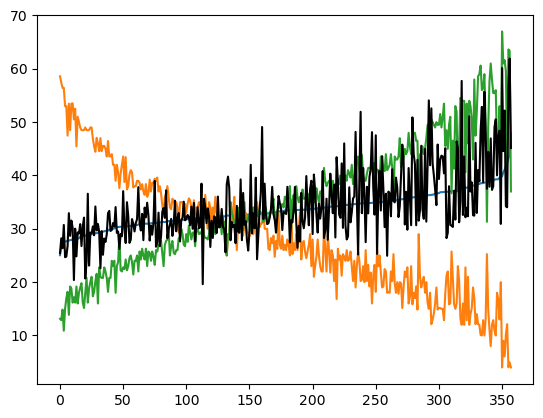

In [70]:
pairs = [
    (
        avgtry(fullscores[i]),
        # prescore[i][0] + prescore[i][1] - (prescore[i][2] + prescore[i][3]),
        fullscores[i][1] + fullscores[i][2],
        fullscores[i][4] + fullscores[i][5],
        prescore[i][0]+prescore[i][1],
        prescore[i][2]+prescore[i][3],
        # fullscores[i][6],
    )
    for i in range(len(subwords))
]

pairs = np.asarray(sorted(pairs, key=lambda e: e[0])).T
plt.plot(np.arange(len(subwords)), pairs[0] * 8)
plt.plot(np.arange(len(subwords)), pairs[1])
plt.plot(np.arange(len(subwords)), pairs[2])
# plt.plot(np.arange(len(subwords)), pairs[3],c='blue')
# plt.plot(np.arange(len(subwords)), pairs[4],c='red')
plt.plot(np.arange(len(subwords)), pairs[4],c='black')
# plt.scatter(pairs[2], pairs[1])

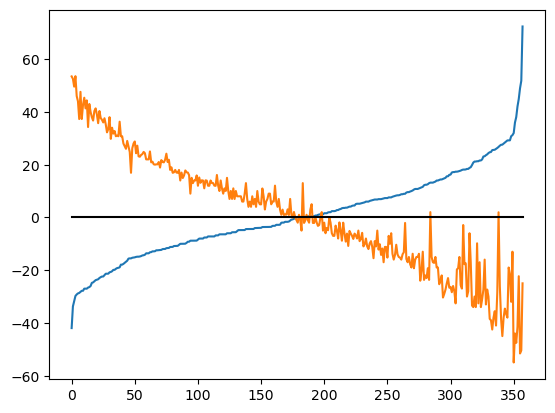

In [71]:
pairs = [
    (
        avgtry(fullscores[i]),
        # prescore[i][0] + prescore[i][1] - (prescore[i][2] + prescore[i][3]),
        fullscores[i][1] + fullscores[i][2] - (fullscores[i][4] + fullscores[i][5])+8.017447199265382,
        prescore[i][0] + prescore[i][1],
        prescore[i][2] + prescore[i][3],
        # fullscores[i][6],
        0,
    )
    for i in range(len(subwords))
]

pairs = np.asarray(sorted(pairs, key=lambda e: e[0])).T
plt.plot(np.arange(len(subwords)), (pairs[0]-4.18) * 40)
plt.plot(np.arange(len(subwords)), pairs[1])
# plt.plot(np.arange(len(subwords)), pairs[2])
# plt.plot(np.arange(len(subwords)), pairs[3],c='blue')
# plt.plot(np.arange(len(subwords)), pairs[4],c='red')
plt.plot(np.arange(len(subwords)), pairs[4], c="black")
# plt.scatter(pairs[2], pairs[1])

In [72]:
avglist = [avgtry(fullscores[i]) for i in range(len(subwords))]
np.median(avglist)

4.18

In [73]:
indexlist=[]
for i in range(len(subwords)):
    if abs(avglist[i]-np.median(avglist))<=0.01:
        indexlist.append(i)

In [74]:
therehold=0
for index in indexlist:
    therehold+=fullscores[index][1]+fullscores[index][2]-(fullscores[index][4]+fullscores[index][5])
therehold/=len(indexlist)
therehold

-8.017447199265382

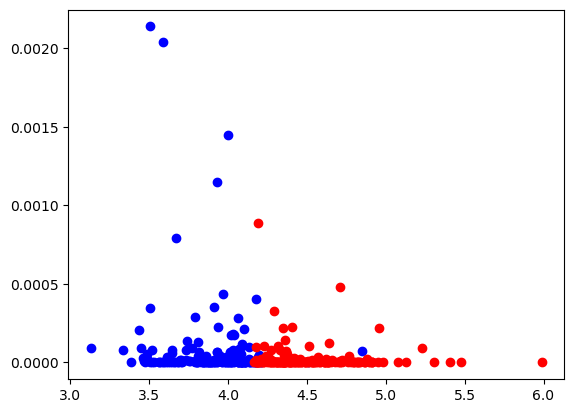

In [75]:
easywordsid = []
hardwordsid = []
for i in range(len(subwords)):
    temp = fullscores[i][1] + fullscores[i][2] - fullscores[i][4] - fullscores[i][5]
    if temp >= therehold:
        easywordsid.append(i)
    else:
        hardwordsid.append(i)
# 5 7 10
# char frequency   combination frequency    word frequency
index=10
# easypairs = [(avgtry(fullscores[i]),features[i][index]) for i in easywordsid]
# hardpairs = [(avgtry(fullscores[i]),features[i][index]) for i in hardwordsid]
# easypairs=np.array(easypairs).T
# hardpairs=np.array(hardpairs).T
# plt.scatter(easypairs[0], easypairs[1], c="blue")
# plt.scatter(hardpairs[0], hardpairs[1], c="red")

# ezavg=0
# hdavg=0
# for i in easywordsid:
#     ezavg+=features[i][index]
# for i in hardwordsid:
#     hdavg+=features[i][index]
# ezavg/=len(easywordsid)
# hdavg/=len(hardwordsid)
# print(ezavg,hdavg)
# print(ezavg>hdavg)

In [76]:
3.3534+ 10.2257- 28.1834- 25.5896

-40.1939

In [77]:
0.472067

0.472067

In [78]:
def getdistribution(word):
    prepartdis=model(torch.FloatTensor(getfeaturefq(word))).detach()
    prefour=func3(prepartdis[0]+prepartdis[1])
    preseven=100- 0.472067-prefour-np.sum(np.array(prepartdis))
    return np.array([ 0.472067,prepartdis[0],prepartdis[1],prefour,prepartdis[2],prepartdis[3],preseven])

In [79]:
getdistribution('eerle')

array([ 0.472067  ,  3.35337329, 10.22566032, 28.74531555, 28.18335342,
       25.58956909,  3.43065643])

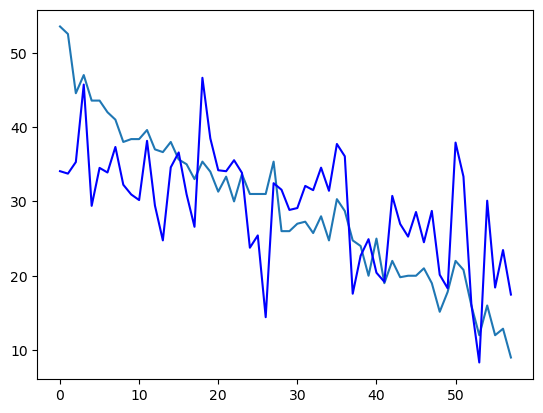

In [80]:
pairs = [
    (
        avgtry(fullscores[i]),
        # prescore[i][0] + prescore[i][1] - (prescore[i][2] + prescore[i][3]),
        fullscores[i][1] + fullscores[i][2],
        fullscores[i][4] + fullscores[i][5],
        prescore[i][0]+prescore[i][1],
        prescore[i][2]+prescore[i][3],
        # fullscores[i][6],
    )
    for i in range(300,len(subwords))
]

pairs = np.asarray(sorted(pairs, key=lambda e: e[0])).T
# plt.plot(np.arange(58), pairs[0] * 8)
plt.plot(np.arange(58), pairs[1])
# plt.plot(np.arange(58), pairs[2])
plt.plot(np.arange(58), pairs[3],c='blue')
# plt.plot(np.arange(58), pairs[4],c='red')
# plt.plot(np.arange(58), pairs[5],c='black')
# plt.scatter(pairs[2], pairs[1])

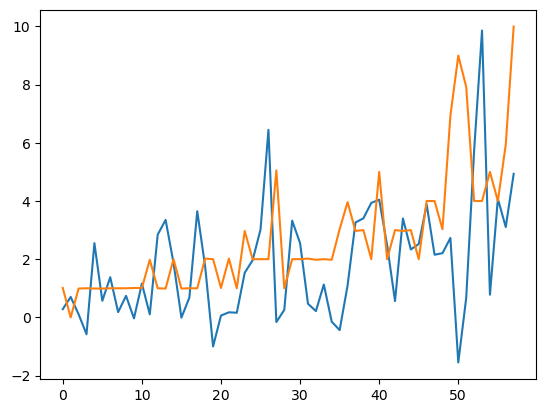

In [81]:
pairs = [
    (
        avgtry(fullscores[i]),
        getdistribution(subwords[i])[6],
        fullscores[i][6]
    )
    for i in range(300,len(subwords))
]

pairs = np.asarray(sorted(pairs, key=lambda e: e[0])).T
# plt.plot(np.arange(58), pairs[0] * 8)
plt.plot(np.arange(58), pairs[1])
plt.plot(np.arange(58), pairs[2])
# plt.plot(np.arange(58), pairs[3],c='blue')
# plt.plot(np.arange(58), pairs[4],c='red')
# plt.plot(np.arange(58), pairs[5],c='black')
# plt.scatter(pairs[2], pairs[1])

In [82]:
beta1 = np.array([-1.73394399, 0.77577143, 0.30261611, -0.7228129])
beta2 = np.array([-1.005841, -0.63922078, -0.38961599, -1.35576767])
beta3 = np.array([-1.12333627, -0.18305615, 0.13764961, -1.25054014])
inter1 = 28.18735398
inter2 = 78.50189256
inter3 = 54.56720889


def func4(t2, t3, t5, t6):
    if t2 + t3 <= 20:
        return np.sum(beta1 * np.array([t2, t3, t5, t6])) + inter1
    elif t2 + t3 >= 30:
        return np.sum(beta2 * np.array([t2, t3, t5, t6])) + inter2
    else:
        return np.sum(beta3 * np.array([t2, t3, t5, t6])) + inter3


def getdistribution2(word):
    prepartdis = model(torch.FloatTensor(getfeaturefq(word))).detach()
    prefour = func4(prepartdis[0], prepartdis[1], prepartdis[2], prepartdis[3])
    preseven = 100 - 0.472067 - prefour - np.sum(np.array(prepartdis))
    return np.array(
        [
            0.472067,
            prepartdis[0],
            prepartdis[1],
            prefour,
            prepartdis[2],
            prepartdis[3],
            preseven,
        ]
    )

In [83]:
fullpre=[]
for i in range(len(subwords)):
    fullpre.append(getdistribution2(subwords[i]))
fullpretry=np.array(fullpre).T
fullscorestry=fullscores.T
# print(fullpretry.shape)
# print(fullscorestry.shape)
for i in range(7):
    print(np.corrcoef(fullpretry[i],fullscorestry[i])[0][1])

0.0
0.6919644095870727
0.6393237318326712
0.4388273855701995
0.6295990872209892
0.5609590854704595
0.5172031382502185


In [84]:
fullpre=[]
for i in range(300,358):
    fullpre.append(getdistribution2(subwords[i]))
fullpretry=np.array(fullpre).T
fullscorestry=fullscores.T[:,300:358]
# print(fullpretry.shape)
# print(fullscorestry.shape)
for i in range(7):
    print(np.corrcoef(fullpretry[i],fullscorestry[i])[0][1])

3.038949454523122e-16
0.7030205874381095
0.5568981651914973
0.2197081459040411
0.6348791423368789
0.4710762286797424
0.1851441598816612


In [85]:
mean1=(min(fullscores[:,1])+max(fullscores[:,1]))/2
mean2=(min(fullscores[:,2])+max(fullscores[:,2]))/2
mean3=(min(fullscores[:,4])+max(fullscores[:,4]))/2
mean4=(min(fullscores[:,5])+max(fullscores[:,5]))/2

for i in range(10):
    for j in range(10):
        for k in range(10):
            for l in range(10):
                

IndentationError: expected an indented block (3951328726.py, line 10)

In [ ]:
getdistribution2("eerie")

array([ 0.472067  ,  6.35387707, 19.52080536, 31.36621184, 28.20413399,
       13.09221554,  0.99068539])

In [ ]:
getdistribution2("eerie")[1]+getdistribution2("eerie")[2]-getdistribution2("eerie")[4]-getdistribution2("eerie")[5]

-15.421667098999023